In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import os
import os.path as osp
import sys
import pickle
import joblib
from collections import Counter
from itertools import product
import torch
import pdb
import random
import tables
from sklearn.linear_model import LogisticRegression, LinearRegression
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score,\
balanced_accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.calibration import CalibratedClassifierCV
import wandb
from wandb.lightgbm import wandb_callback, log_summary
from dill.source import getsource
from dill import detect
import functools

In [2]:
print(np.__version__)
print(pd.__version__)

1.21.5
1.2.4


### set the seeds and change to current directory + set the output directory

In [3]:
SEED=90210
np.random.seed(SEED)
os.environ['USER_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/'
os.environ['OUT_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory'

In [4]:
os.chdir('/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/')
from AnalysisFuncs import plotCorr, getPred_fromProb, getMetrics, getCorr, getGroundTruth, getURange
from AnalysisFuncs import getResiduals, plotDistributionProbs, plotCorr_w_Unobs, trainHardPseudo, StackedBarDI
from AnalysisFuncs import saveFile, loadFile, getTrainTestIdx

In [5]:
%reload_ext autoreload
%autoreload 2

### Create function to pickle functions

In [6]:
def function_to_string(fn):
    return getsource(detect.code(fn)) 

In [7]:
processed_data_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk')

In [8]:
# load df_cleaned and test_idxs
df_cleaned = loadFile(processed_data_path, 'df_cleaned.csv')
df_sf = loadFile(processed_data_path, 'processed_df.csv')
test_idxs = loadFile(processed_data_path, '/sigmoid/after_cal/test_idxs.npy')
cal_idxs = loadFile(processed_data_path, '/sigmoid/after_cal/cal_idxs.npy')
train_idxs = loadFile(processed_data_path, '/train_idxs.npy')
val_idxs = loadFile(processed_data_path, '/val_idxs.npy')

/home/rr568/.conda/envs/icu-benchmark/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):


In [9]:
tr=len(train_idxs)
v=len(val_idxs)
t=len(test_idxs)
cal=len(cal_idxs)
assert len(np.intersect1d(train_idxs, val_idxs))==0
assert len(np.intersect1d(test_idxs, val_idxs))==0
assert len(np.intersect1d(train_idxs, test_idxs))==0
assert len(np.intersect1d(train_idxs, cal_idxs))==0
assert len(np.intersect1d(test_idxs, cal_idxs))==0
assert len(np.intersect1d(val_idxs, cal_idxs))==0
print(f"train %:{tr*100/(tr+v+cal+t):.2f}, val %:{v*100/(tr+v+cal+t):.2f}, cal %:{cal*100/(tr+v+cal+t):.2f}, test %:{t*100/(tr+v+cal+t):.2f}")

train %:45.00, val %:5.00, cal %:25.00, test %:25.00


In [10]:
df_cleaned

,year,date,time,precinct,xcoord,ycoord,serial,radio.run,inside.outside,location.housing,...,found.gun,found.weapon,id,lat,lon,month,hour,T,D,D_and_T
0,2008,2008-01-01 00:00:00,1900-01-01 01:30:00,42,1009873.0,243953.0,1044,False,False,neither,...,False,False,978588,40.836233,-73.907403,1,1,True,0.0,False
1,2008,2008-01-01 00:00:00,1900-01-01 20:10:00,108,1001546.0,210784.0,3,True,True,neither,...,False,False,978589,40.745213,-73.937580,1,20,False,NaN,False
2,2008,2008-01-08 00:00:00,1900-01-01 01:00:00,100,1042944.0,154180.0,15,False,False,housing,...,False,False,978590,40.589670,-73.788672,1,1,True,0.0,False
3,2008,2008-01-08 00:00:00,1900-01-01 19:05:00,103,1050245.0,196802.0,210,False,False,neither,...,False,False,978591,40.706607,-73.761968,1,19,True,0.0,False
4,2008,2008-01-12 00:00:00,1900-01-01 21:25:00,71,995112.0,180043.0,90,False,True,housing,...,False,False,978592,40.660846,-73.960850,1,21,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213079,2011,2011-12-31 00:00:00,1900-01-01 23:55:00,115,1018538.0,211977.0,18291,True,False,neither,...,False,False,3387062,40.748438,-73.876252,12,23,True,0.0,False
2213080,2011,2011-12-31 00:00:00,1900-01-01 23:58:00,23,998096.0,227863.0,17949,False,False,housing,...,False,False,3387063,40.792097,-73.949996,12,23,True,0.0,False
2213081,2011,2011-12-31 00:00:00,1900-01-01 23:58:00,40,1006936.0,234238.0,17559,False,False,neither,...,False,False,3387064,40.809576,-73.918049,12,23,True,0.0,False
2213082,2011,2011-12-31 00:00:00,1900-01-01 23:58:00,40,1006936.0,234238.0,17555,False,False,neither,...,False,False,3387065,40.809576,-73.918049,12,23,True,0.0,False


In [11]:
# calibrate_method='calibrate_by_bins'
calibrate_method='sigmoid'
#use isotonic regression for calibration in the path to save the model
processed_data_path = osp.join(processed_data_path, calibrate_method)

In [12]:
processed_data_path

'/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory/stop_and_frisk/sigmoid'

In [13]:
LGBM_T = loadFile(osp.join(processed_data_path,'predict_T'),'LGBM_T.pkl')
LGBM_D_given_T = loadFile(osp.join(processed_data_path,'predict_D_given_T'),'LGBM_D_given_T.pkl')
LGBM_D_given_T_ipw = loadFile(osp.join(processed_data_path,'predict_D_given_T_ipw'),'LGBM_D_given_T_ipw.pkl')
LGBM_D_and_T =loadFile(osp.join(processed_data_path,'predict_D_and_T'),'LGBM_D_and_T.pkl')
LGBM_D_pseudo = loadFile(osp.join(processed_data_path,'predict_D_pseudo'),'LGBM_D_pseudo.pkl')

In [14]:
test_X = loadFile(processed_data_path,'/after_cal/test_X.npy')
cal_X = loadFile(processed_data_path,'/after_cal/cal_X.npy')

In [15]:
models=['LGBM']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
clf_list=[LGBM_T, LGBM_D_given_T, LGBM_D_given_T_ipw,
          LGBM_D_and_T, LGBM_D_pseudo]
clf_dict={}
i=0
for t in tasks:
    clf_dict[t]={}
    for m in models:
        clf_dict[t][m]=clf_list[i]
        i+=1
dict_df_labels={}
dict_df_probs={}
dict_df_ids={}
dict_models={}
probs_path=processed_data_path
alpha=0.1
figsize1=(5,50)
figsize2=(10,10)
df_pp=pd.DataFrame({'AUC' : [],'PR':[],'BalancedAcc':[],'modelName':[],'rowName':[]})

In [16]:
processed_data_path

'/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory/stop_and_frisk/sigmoid'

 calibrating by bins with cal data
val max:27664, val min:27663
 number of bins in test :20
calibrated_preds
0.092105    0.091395
0.156593    0.155320
0.199400    0.199739
0.245807    0.245709
0.293208    0.291196
0.331405    0.332720
0.373712    0.377550
0.421342    0.418309
0.468026    0.470861
0.519412    0.532320
0.586524    0.583250
0.650051    0.645412
0.709504    0.708694
0.781087    0.784089
0.832122    0.833042
0.870120    0.871005
0.899252    0.901640
0.923294    0.925303
0.947945    0.949853
0.969383    0.970003
Name: ground_truth, dtype: float64
auc_score:0.832
auc_score:0.832
classification report for model LGBM, task T: 
               precision    recall  f1-score   support

       False       0.62      0.62      0.62    241386
        True       0.71      0.71      0.71    311885

    accuracy                           0.67    553271
   macro avg       0.66      0.66      0.66    553271
weighted avg       0.67      0.67      0.67    553271

 calibrating by bins with cal

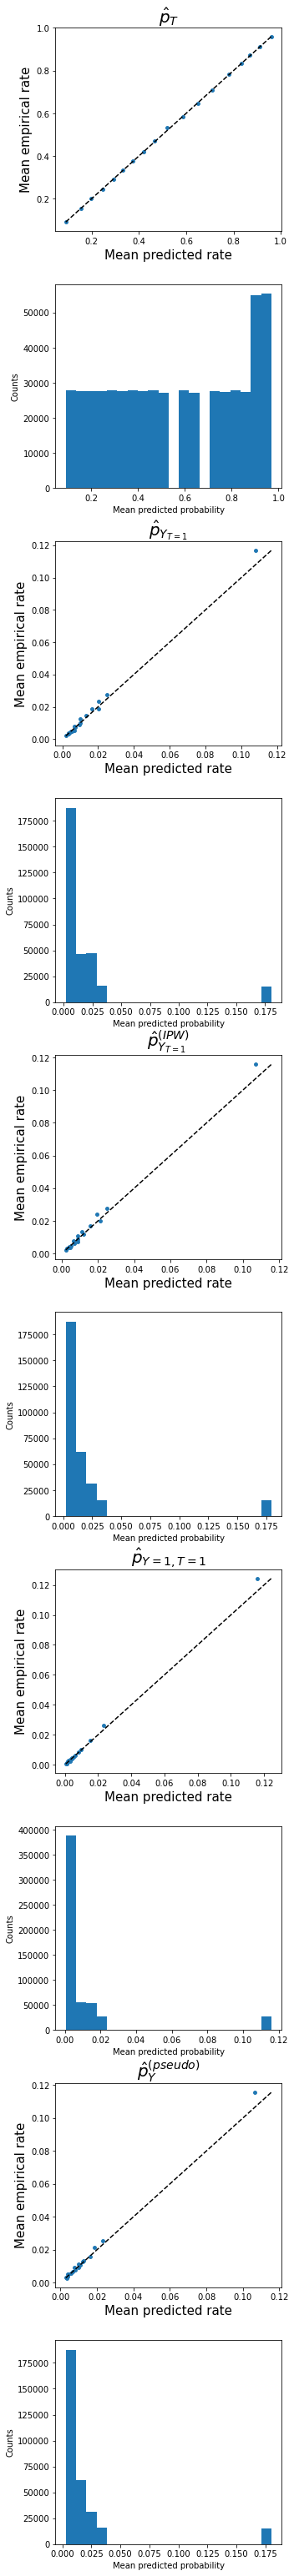

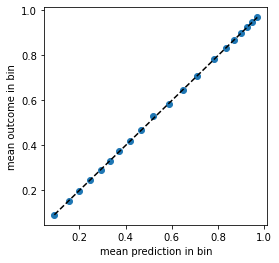

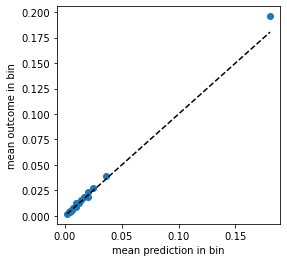

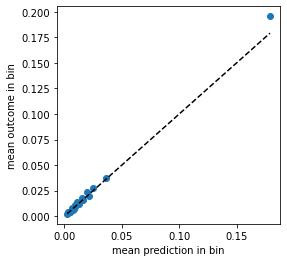

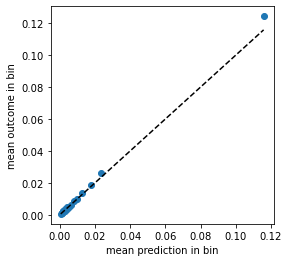

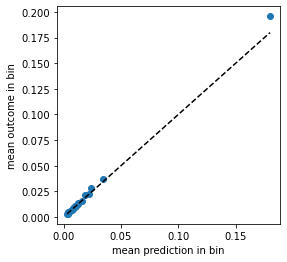

T and D|T probs for model LGBM: (0.2378840722401619, 0.0)
T and D,T probs for model LGBM: (0.38006082287668874, 0.0)
D,T and D|T probs for model LGBM: (0.7668522136980908, 0.0)


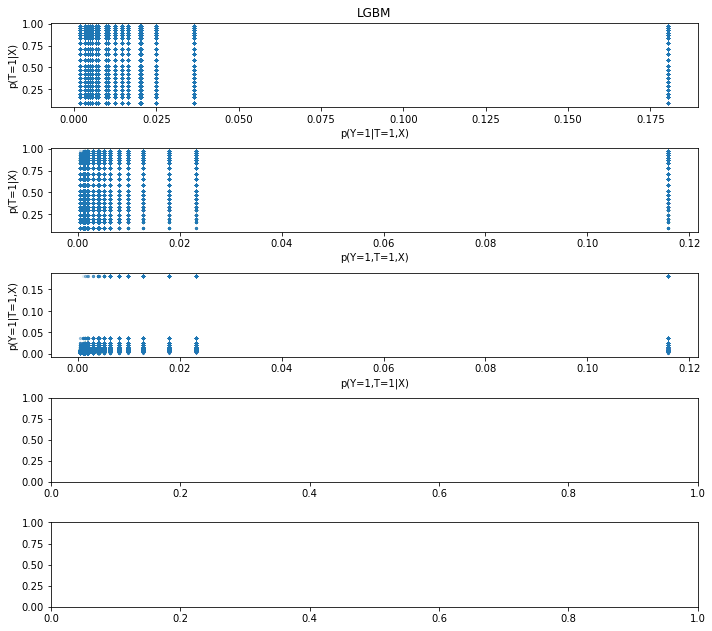

In [17]:
dict_df_labels, dict_df_probs, dict_models, df_pp = getCorr(models, tasks, test_X.copy(), clf_dict, df_sf.copy(), 
        test_idxs.copy(), dict_df_labels, dict_df_probs, dict_models, df_pp, probs_path, calibrate=True, 
        figsize1=figsize1, figsize2=figsize2, alpha=alpha, cal_idxs=cal_idxs, cal_X=cal_X)

In [18]:
dict_df_labels['LGBM']

,T,D|T,D|T_ipw,D_and_T,D_pseudo
0,False,NaN,NaN,False,NaN
1,False,NaN,NaN,False,NaN
2,False,NaN,NaN,False,NaN
3,False,NaN,NaN,False,NaN
4,True,0.0,0.0,False,0.0
...,...,...,...,...,...
553266,True,0.0,0.0,False,0.0
553267,True,0.0,0.0,False,0.0
553268,True,0.0,0.0,False,0.0
553269,True,0.0,0.0,False,0.0


In [19]:
corr_mat=dict_df_probs['LGBM'].corr(method='pearson')
np.linalg.eigvals(corr_mat)

array([3.67833014, 0.8903918 , 0.25823543, 0.1101384 , 0.06290423])

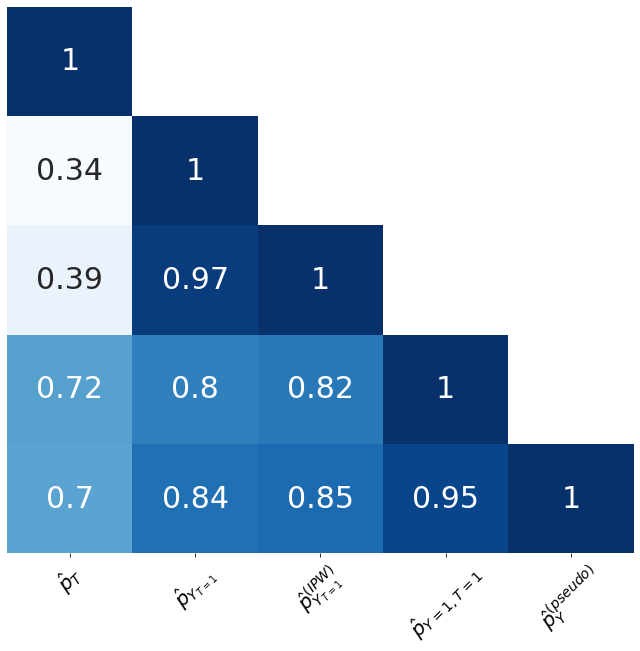

In [20]:
title='policing correlation matrix'
corr_method="spearman"
figsize=(9, 10)
top_adjust=0.9
title_en=False
plotCorr(models, dict_df_probs, title, corr_method, figsize=figsize, top_adjust=top_adjust,
         title_en=title_en, savefig_path=processed_data_path)

In [21]:
assert not np.isnan(dict_df_probs['LGBM']['T'].values).any()

lines did not cross


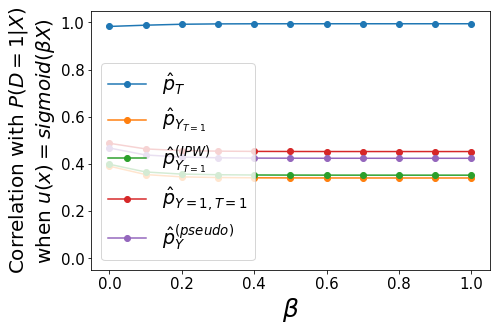

In [22]:
title=r'Correlation with $P(D=1|X)$' '\n' r'when $u(x)=sigmoid(\beta X)$'
# models=['LogisticRegression', 'LGBM']
models=['LGBM']
# tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'product_T_D_given_T', 'D_pseudo']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
figsize=(7,5)
# figsize=(10,7)
top_adjust=0.9
# tasks=['T', 'D|T']
corr_method=stats.pearsonr
title_en=True
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, alpha=['sigmoid'],X=test_X, corr_method=corr_method,
                 figsize=figsize, top_adjust=top_adjust, title_en=title_en)

lines did not cross


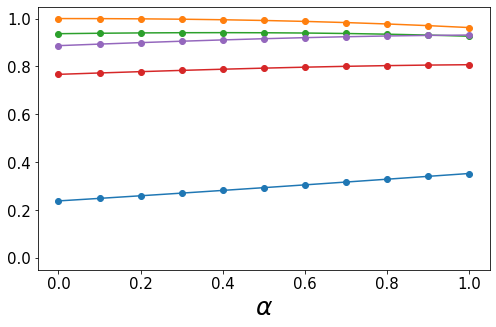

In [23]:
title=r'Correlation with $P(D=1|X)$' '\n' r'when $u(x)=\alpha P(D=1|T=1,X)$'
# models=['LogisticRegression', 'LGBM']
models=['LGBM']
# tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T', 'product_T_D_given_T', 'D_pseudo']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
figsize=(7,5)
# figsize=(10,7)
top_adjust=0.9
# tasks=['T', 'D|T']
corr_method=stats.pearsonr
loc="center left"
# loc="lower left"
title_en=False
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, alpha=np.arange(0,1.1,0.1), corr_method=corr_method,
                 figsize=figsize, top_adjust=top_adjust, title_en=title_en, loc=loc)

lines did not cross
[[0.99983627 0.34438652]
 [0.34438652 1.00016375]], spearman from lib:SpearmanrResult(correlation=0.3443865242397813, pvalue=0.0), var of D:25436996090.176235, var of T :25445327502.365437
 the point of crossover would be :0.11285447942969323 with std for p_D_T1:0.03205533849213941 and std for p_T:0.2840413482400531


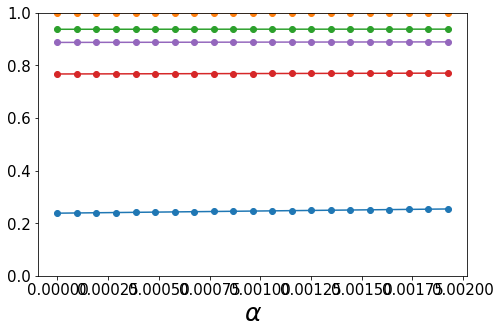

In [24]:
title=r'Correlation with $P(D=1|X)$' '\n' r'when $u(x)=\alpha$ is constant'
models=['LGBM']
# tasks=['T', 'D|T']
corr_method=stats.pearsonr
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
figsize=(7,5)
# figsize=(10,7)
# loc="center left"
loc="lower left"
title_en=False
plotCorr_w_Unobs(dict_df_probs, models, title, tasks, corr_method=corr_method,
                 figsize=figsize, loc=loc, title_en=title_en, custome_ticker=True)

In [25]:
df_probs_stats=pd.DataFrame({'model' : [],'task':[],'mean':[],'std':[], 'min':[], 'max':[]})
tasks=['T','D|T']
for m in models:
    for t in tasks:
        df_probs_stats=df_probs_stats.append({'model' : m,'task':t,'mean':dict_df_probs[m][t].mean(),
                               'std':dict_df_probs[m][t].std(), 'min':dict_df_probs[m][t].min(),
                                'max': dict_df_probs[m][t].max()}, ignore_index=True)
        print(f" mean , std, min. for model {m} and task {t}: {dict_df_probs[m][t].mean():.3f}, {dict_df_probs[m][t].std():.3f}, {dict_df_probs[m][t].min():.3f}")

 mean , std, min. for model LGBM and task T: 0.563, 0.284, 0.092
 mean , std, min. for model LGBM and task D|T: 0.016, 0.032, 0.002


In [26]:
df_probs_stats

,model,task,mean,std,min,max
0,LGBM,T,0.562863,0.284042,0.092105,0.969383
1,LGBM,D|T,0.016027,0.032055,0.001924,0.180384


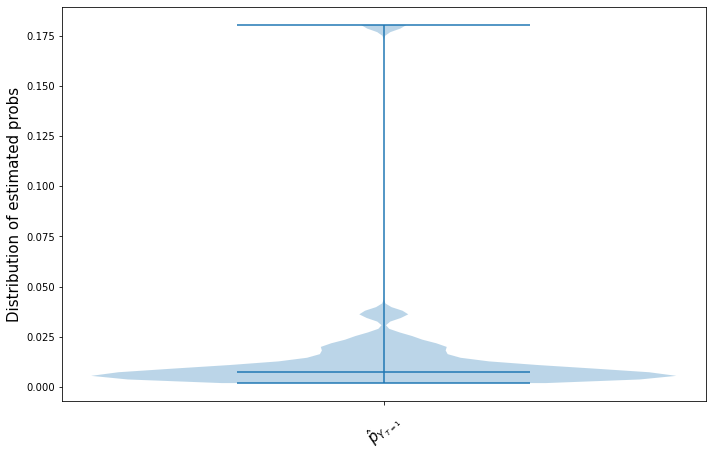

In [27]:
title='Distribution of estimated probs'
models=['LGBM']
tasks=['D|T']
figsize=(10,7)
plotDistributionProbs(dict_df_probs, models, title, tasks, figsize=figsize)

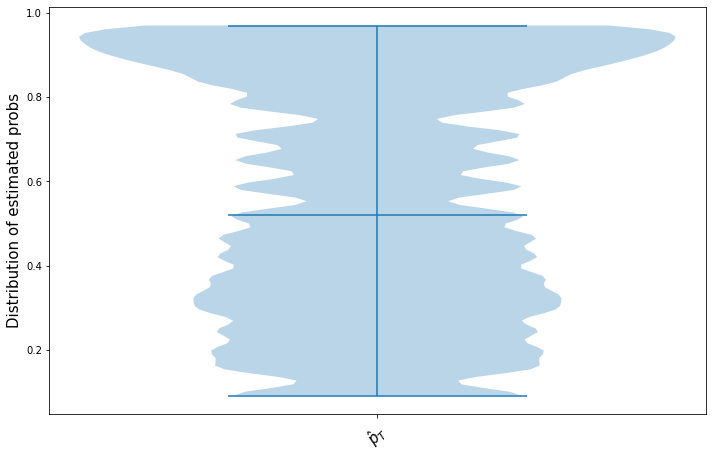

In [28]:
title='Distribution of estimated probs'
models=['LGBM']
tasks=['T']
figsize=(10,7)
plotDistributionProbs(dict_df_probs, models, title, tasks, figsize=figsize)

for model :LGBM


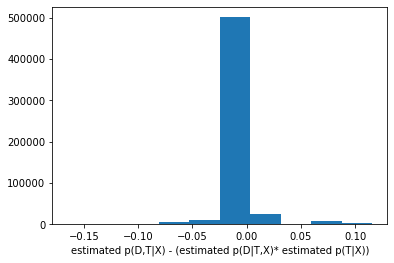

In [29]:
for m in models:
    print(f"for model :{m}")
    getResiduals(dict_df_probs[m]['D_and_T'], dict_df_probs[m]['D|T'], dict_df_probs[m]['T'])

 top 25.00 % samples mean :0.9217033292884484
 top 25.00 % samples mean :0.044340708060809246
 top 25.00 % samples mean :0.043650878925336076
 top 25.00 % samples mean :0.035865489489215814
 top 25.00 % samples mean :0.04078786955531165


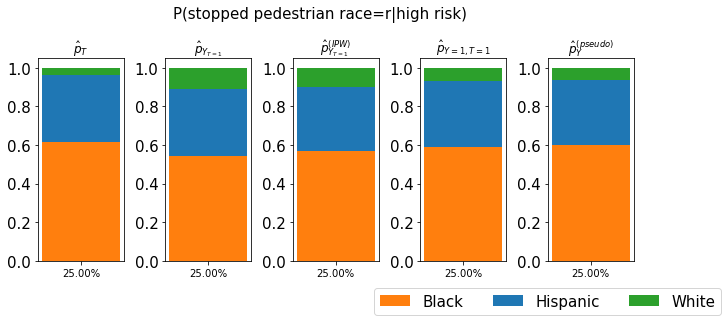

In [30]:
# title='Fraction of a particular Race for top-k'
title=r'P(stopped pedestrian race=r|high risk)'
models=['LGBM']
tasks=['T', 'D|T', 'D|T_ipw', 'D_and_T','D_pseudo']
figsize=(9,4)
top_adjust=0.8
fracs_sf=StackedBarDI(dict_df_probs, df_cleaned.iloc[test_idxs].copy(), models, tasks, title, 
             figsize=figsize, top_adjust=top_adjust)

In [31]:
processed_data_path

'/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory/stop_and_frisk/sigmoid'

In [32]:
probs_T=loadFile(osp.join(processed_data_path,'probs_T'), '/probs.npy')
probs_D_given_T=loadFile(osp.join(processed_data_path,'probs_D|T'), '/probs.npy')

In [33]:
stats.spearmanr(probs_T, probs_D_given_T)

SpearmanrResult(correlation=0.34438652423978133, pvalue=0.0)

In [34]:
stats.pearsonr(probs_T, probs_D_given_T)

(0.2378840722401619, 0.0)

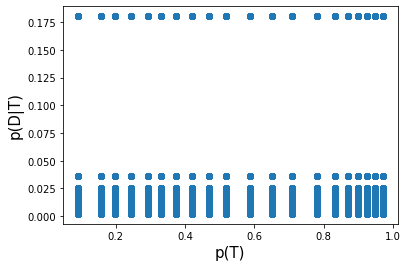

In [35]:
plt.scatter(probs_T, probs_D_given_T, alpha=0.1)
plt.ylabel('p(D|T)', fontsize=15)
plt.xlabel('p(T)', fontsize=15)
plt.show()
plt.close()

In [36]:
# predicted mean vs empirical mean
# n_bins=20
# probs_D_given_T_not_nan=dict_df_probs['LGBM']['D|T'].values
# sorted_probs_idxs = np.argsort(probs_D_given_T_not_nan)
# idxs_bins = np.array_split(sorted_probs_idxs, n_bins)
# df_mean_bins=pd.DataFrame({'bin' : [],'prob_mean':[],'empirical_mean':[], 'len':[]})
# for i in range(n_bins):
#     df_mean_bins=df_mean_bins.append({'bin' : i,'prob_mean':probs_D_given_T_not_nan[idxs_bins[i]].mean(),
#                         'empirical_mean':test_y_D_given_T[idxs_bins[i]].mean(), 'len':len(idxs_bins[i])},
#                          ignore_index=True)
# df_mean_bins

In [37]:
dict_df_probs['LGBM']

,T,D|T,D|T_ipw,D_and_T,D_pseudo
0,0.421342,0.010135,0.008788,0.002024,0.006864
1,0.092105,0.004811,0.003015,0.000542,0.003015
2,0.331405,0.004811,0.004426,0.001410,0.003528
3,0.245807,0.005388,0.004234,0.001844,0.004554
4,0.969383,0.020399,0.021233,0.017821,0.022132
...,...,...,...,...,...
553266,0.709504,0.016422,0.015652,0.009832,0.012316
553267,0.969383,0.009815,0.008917,0.009832,0.012702
553268,0.709504,0.001924,0.002309,0.001301,0.003528
553269,0.969383,0.010135,0.012253,0.115855,0.016294


In [38]:
colNames=['location.housing', 'precinct']
for f in colNames:
    print(df_cleaned[f].unique())

['neither' 'housing' 'transit']
[ 42 108 100 103  71  25   6  30  88  23  73  10  32  26   9  90  33  79
  67  43  77  50  40  47  14 110  24 122   1  17  72  13  83 115  28  20
   5  76 105  62  44  94  60  84  75  34   7  49 104  69  45 114 123  81
 102  46 106  19 113 109  68  18 120  48  70 101 112 107  52 111  63  66
  61  78  41  22]


In [39]:
df_cleaned.loc[df_cleaned['location.housing']=='transit'].groupby(['precinct'])['D'].agg(['mean', 'size'])

,mean,size
precinct,,
1,0.031886,6177
5,0.035068,3307
6,0.028973,3721
7,0.109060,1160
9,0.107547,1248
...,...,...
109,0.136792,505
110,0.144262,1636
112,0.129114,1268


In [40]:
fracs_sf

{'T': {'Black': [0.6134965333256216],
  'Hispanic': [0.3508534742656362],
  'White': [0.03564999240874224]},
 'D|T': {'Black': [0.5455367019238416],
  'Hispanic': [0.34425269489650584],
  'White': [0.11021060317965253]},
 'D|T_ipw': {'Black': [0.5673922945118821],
  'Hispanic': [0.3334297302573075],
  'White': [0.09917797523081039]},
 'D_and_T': {'Black': [0.5913517499656586],
  'Hispanic': [0.34263322657374],
  'White': [0.06601502346060137]},
 'D_pseudo': {'Black': [0.5996515251198334],
  'Hispanic': [0.33809293145455727],
  'White': [0.06225554342560929]}}

In [41]:
#save fracs_sf

saveFile(processed_data_path, fracs_sf, "fracs_sf.pkl")